## Adversarial Attack and Defense

### Import libraries and packages

In [18]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import ImageFolder
from mechanism import Attack
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt

CUDA if desired and available. Note, a GPU with CUDA is not critical as a CPU will not take much time.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model under attack

ConvNeXt Base model architecture from the [A ConvNet for the 2020s paper](https://arxiv.org/abs/2201.03545).

- Define the model, then initialize the model and load the pretrained weights.

Ref:
- https://pytorch.org/vision/main/_modules/torchvision/models/convnext.html
- https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_base.html#torchvision.models.ConvNeXt_Base_Weights

In [20]:
download_url('https://download.pytorch.org/models/convnext_base-6075fbad.pth', '.')
pretrained_model_convnext_base = 'convnext_base-6075fbad.pth'

Using downloaded and verified file: ./convnext_base-6075fbad.pth


In [21]:
model = torchvision.models.convnext_base(weights='DEFAULT')
model = model.to(device)

#### Model summary

We have a pretrained model so we will just put it in eval mode to skip dropout etc layers.

In [22]:
model.load_state_dict(torch.load(pretrained_model_convnext_base, map_location=device))
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in

#### Imagenet labels

The file is already present in the repository. You can also download the labels/class file from this [link](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

- Split the file into key-value dictionary where key is the index and value is a list of string with labels. e.g. 21 : ['kite']
- We only need to worry about 10 classes because this dataset has only 10 classes from the 1000 classes mentioned in the link above.

In [23]:
labels_file = 'imagenet1000_clsidx_to_labels.txt'

with open(labels_file, "r") as file:
    contents = file.readlines()

labels = {}

for line in contents:
    line = line.strip()
    key, value = line.split(":")
    key = int(key)
    value = value.strip(" '")
    value = value.strip("',")
    value = value.split(", ")
    labels[key] = value
    
small_dataset = {0:0, 217:1, 482:2, 491:3, 497:4, 566:5, 569:6, 571:7, 574:8, 701:9}
label = {0:labels[0], 1:labels[217], 2:labels[482], 3:labels[491], 4:labels[497], 
         5:labels[566], 6:labels[569], 7:labels[571], 8:labels[574], 9:labels[701]}

In [24]:
def count_files(path):
    count = []
    for _, _, files in os.walk(path):
        if files == []:
            continue
        else:
            count.append(len(files))
    return count
    
train_count = count_files('data/imagenette2-320/train')
test_count = count_files('data/imagenette2-320/val')

#### Test dataset and dataloader declaration

Transform the dataset to tensor and define the dataloader. Note, we are not TRANSFORMING AND AUGMENTING IMAGES.

In [25]:
train_transform = transforms.Compose([
                          transforms.ToTensor()])
                         
test_transform = transforms.Compose([
                         transforms.ToTensor()])

ds_train = ImageFolder('data/imagenette2-320/train', train_transform)
ds_test  = ImageFolder('data/imagenette2-320/val', test_transform)

In [26]:
def add_target(count, ds):
    target = []
    for i in range(10):
        for j in range(count[i]):
            target.append(ds.classes[i])
    return target

ds_train.target = add_target(train_count, ds_train)
ds_test.target = add_target(test_count, ds_test)

dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1)

#### Test function

Each call to this test function performs a full test step on the MNIST test set and reports a final accuracy. However, notice that this function also takes an epsilon input. This is because the test function reports the accuracy of a model that is under attack from an adversary with strength ϵ. More specifically, for each sample in the test set, the function computes the gradient of the loss w.r.t the input data (data_grad), creates a perturbed image with attack (perturbed_data), then checks to see if the perturbed example is adversarial. In addition to testing the accuracy of the model, the function also saves and returns some successful adversarial examples to be visualized later.

In [27]:
def test(model, device, test_loader, epsilon, attack_type):
    correct = 0
    adv_examples = []
    attack = Attack(epsilon)
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        
        if init_pred.item() not in small_dataset.keys():
            continue
        elif small_dataset[init_pred.item()]!= target.item():
            continue
        
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        
        if attack_type == 'fgsm':
            perturbed_image = attack.fgsm(data, data_grad)
        elif attack_type == 'ifgsm':
            perturbed_image = attack.ifgsm(data, data_grad)
            
        output = model(perturbed_image)
        final_pred = output.max(1, keepdim=True)[1]
        
        
        if final_pred.item() in small_dataset.keys():
            if small_dataset[final_pred.item()] == target.item():
                correct += 1
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                    adv_examples.append( (small_dataset[init_pred.item()], small_dataset[final_pred.item()], adv_ex) )
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                    adv_examples.append( (small_dataset[init_pred.item()], small_dataset[final_pred.item()], adv_ex) )        

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {}/{} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

#### Visualization

- Graph to visualize how accuracy goes down with increase in epsilon
- Some examples visualization where the model predicts wrong labels for the images.

In [28]:
def plot_graph(accuracies):
    plt.figure(figsize=(7,7))
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.0, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

In [29]:
def visualize_adversarial(examples):
    cnt = 0
    plt.figure(figsize=(15,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons), len(examples[0]), cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(label[orig][0], label[adv][0]))
            plt.imshow(ex[0,:,:])

    plt.tight_layout()
    plt.show()

### Run attack
#### 1. Fast Gradient Sign Method [FGSM]

We've also used epsilon=0 to see how the model performs when there is no attack.

In [30]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [14]:
accuracies_fgsm_attack = []
examples_fgsm_attack = []

for eps in epsilons:
    acc, ex = test(model, device, dataloader_test, eps, attack_type="fgsm")
    accuracies_fgsm_attack.append(acc)
    examples_fgsm_attack.append(ex)

Epsilon: 0	Test Accuracy = 3351/3929 = 0.8528887757699161
Epsilon: 0.05	Test Accuracy = 1317/3929 = 0.3351997963858488
Epsilon: 0.1	Test Accuracy = 950/3929 = 0.24179180453041485
Epsilon: 0.15	Test Accuracy = 514/3929 = 0.1308220921354034
Epsilon: 0.2	Test Accuracy = 229/3929 = 0.05828455077627895
Epsilon: 0.25	Test Accuracy = 111/3929 = 0.028251463476711633
Epsilon: 0.3	Test Accuracy = 53/3929 = 0.013489437515907355


As can be seen, the accuracy keeps on droping with increase in epsilon.

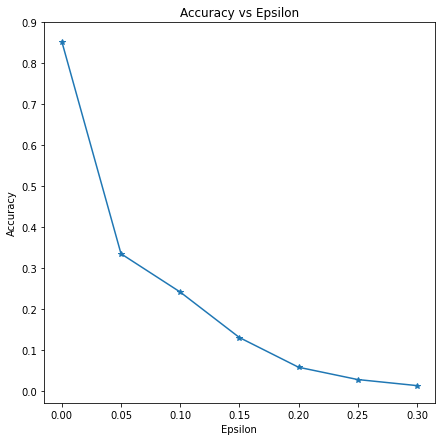

In [15]:
plot_graph(accuracies_fgsm_attack)

In the first row below it can be clearly seen that when epsilon=0, the model gives the correct label to the image. In all the first row images a fish called 'tench' can be seen.

In the other rows as the epsilon increases the prediction fails and the fish called 'tench' is sometimes labeled as envelope, matchstick, wall clock etc.

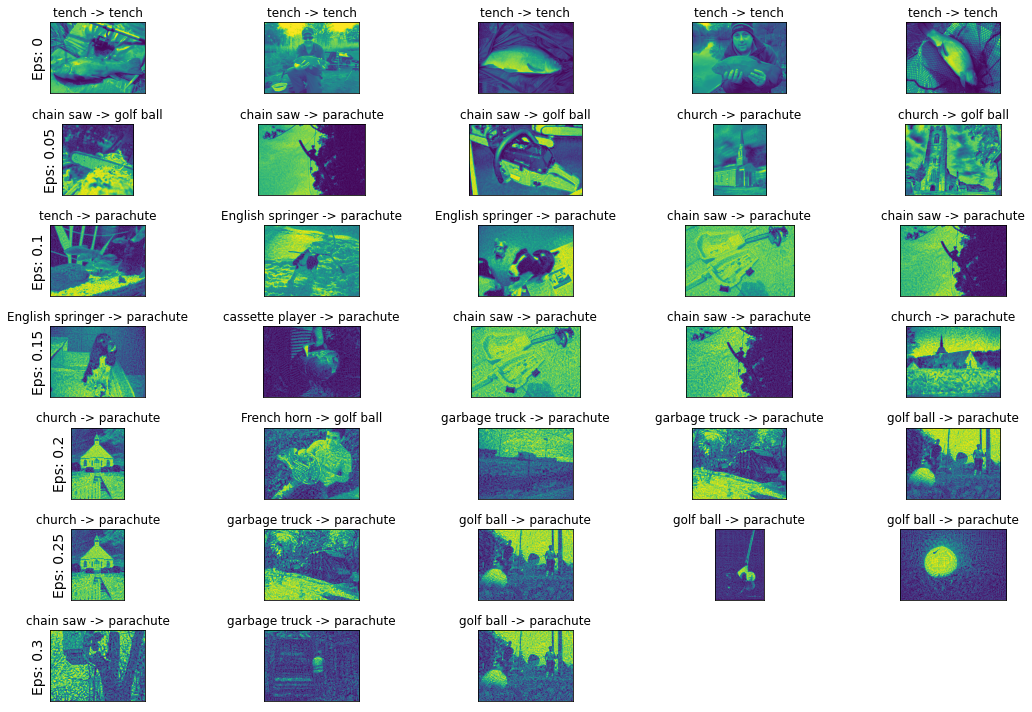

In [16]:
visualize_adversarial(examples_fgsm_attack)

#### 2. Iterative Fast Gradient Sign Method [IFGSM]

We've also used epsilon=0 to see how the model performs when there is no attack.

In [31]:
accuracies_ifgsm_attack = []
examples_ifgsm_attack = []

for eps in epsilons:
    acc, ex = test(model, device, dataloader_test, eps, attack_type="ifgsm")
    accuracies_ifgsm_attack.append(acc)
    examples_ifgsm_attack.append(ex)

Epsilon: 0	Test Accuracy = 3351/3929 = 0.8528887757699161
Epsilon: 0.05	Test Accuracy = 1370/3929 = 0.34868923390175616
Epsilon: 0.1	Test Accuracy = 1027/3929 = 0.26138966658182744
Epsilon: 0.15	Test Accuracy = 629/3929 = 0.1600916263680326
Epsilon: 0.2	Test Accuracy = 323/3929 = 0.08220921354034105
Epsilon: 0.25	Test Accuracy = 153/3929 = 0.03894120641384576
Epsilon: 0.3	Test Accuracy = 86/3929 = 0.02188852125222703


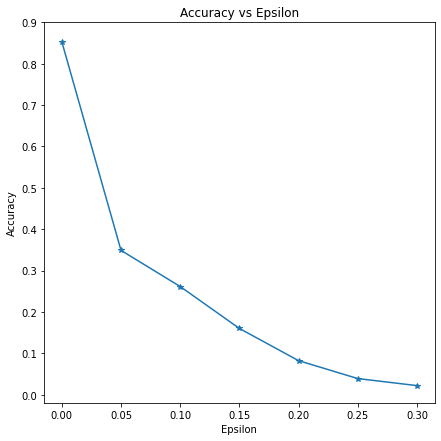

In [32]:
plot_graph(accuracies_ifgsm_attack)

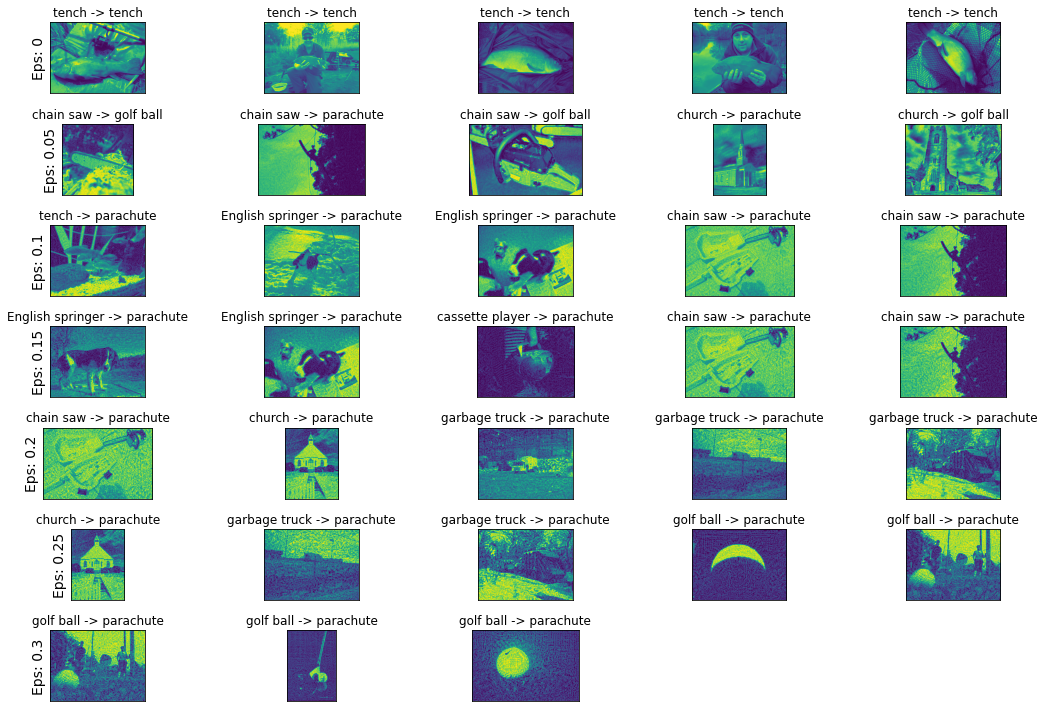

In [33]:
visualize_adversarial(examples_ifgsm_attack)

### Defense

As a defense mechanism to the above Iterative Fast Gradient Sign method, I've implemented Input Transformation method. The method was originally published by researchers at Facebook.

In this method the author Guo, Chuan et. al. suggest applying image transformations such as bit-depth reduction, JPEG compression, total variance minimization, and image quilting before feeding the image to a convolutional network classifier. On ImageNet they showed that total variance minimization and image quilting are very effective defenses in practice.

In my experiment I've added normalization, resizing, and crop transformation mechanism and tested by applying adversary.

Other transformation such as below was also tried however the results weren't good.

```
transform=T.Compose([T.RandomOrder((
                    T.AutoAugment(policy=AutoAugmentPolicy.IMAGENET, interpolation=InterpolationMode.BILINEAR),
                    T.RandAugment(),
                    T.TrivialAugmentWide() )),
                    T.Resize((256, 256)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]) ]))
```
Ref: [Countering Adversarial Images using Input Transformations](https://arxiv.org/abs/1711.00117)

In [36]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize((256,256)),
                        transforms.CenterCrop((224,224)),
                        transforms.ToTensor(),
                        normalize])
                         
test_transform = transforms.Compose([transforms.Resize((256,256)),
                        transforms.CenterCrop((224,224)),
                        transforms.ToTensor(),
                        normalize])

ds_train = ImageFolder('data/imagenette2-320/train', train_transform)
ds_test  = ImageFolder('data/imagenette2-320/val', test_transform)

def add_target(count, ds):
    target = []
    for i in range(10):
        for j in range(count[i]):
            target.append(ds.classes[i])
    return target

ds_train.target = add_target(train_count, ds_train)
ds_test.target = add_target(test_count, ds_test)

dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1)

Below is a method for plotting the accuracy changes observed with attack and defense.

In [37]:
def plot_difference(attack_accuracy, defense_accuracy):
    fig = plt.figure(figsize=(7,7))
    plt.yticks(np.arange(0, 1.0, step=0.1))
    plt.xticks(np.arange(0, 0.35, step=0.05))
    plt.plot(epsilons, attack_accuracy, "*-", label="Attack")
    plt.plot(epsilons, defense_accuracy, "o-", label="Defense")
    plt.title("Attack vs Defense")
    plt.xlabel("Epsilons")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### Run defense
#### Input Transformations
I've implemented input transform defense mechanism.

Steps:
1. Apply input transform to data
2. Attack the model but pass the transformed data.
3. Observe whether the attack is successful or unsuccessful.

In [38]:
accuracies_ifgsm_defense = []
examples_ifgsm_defense = []

for eps in epsilons:
    acc, ex = test(model, device, dataloader_test, eps, attack_type="ifgsm")
    accuracies_ifgsm_defense.append(acc)
    examples_ifgsm_defense.append(ex)

Epsilon: 0	Test Accuracy = 2924/3929 = 0.744209722575719
Epsilon: 0.05	Test Accuracy = 2747/3929 = 0.699160091626368
Epsilon: 0.1	Test Accuracy = 2606/3929 = 0.6632730974802749
Epsilon: 0.15	Test Accuracy = 2460/3929 = 0.6261135148892848
Epsilon: 0.2	Test Accuracy = 2314/3929 = 0.5889539322982947
Epsilon: 0.25	Test Accuracy = 2154/3929 = 0.5482311020615933
Epsilon: 0.3	Test Accuracy = 1998/3929 = 0.5085263425808094


As can be observed from the accuracies we have succesfully defended the IFGSM attack using Input Transform defense mechanism. The drop in accuracy is minimal and we observe a consistent result.

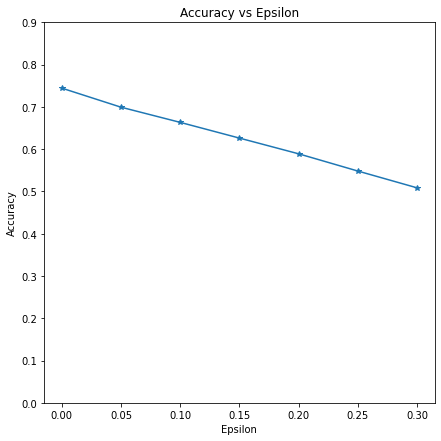

In [39]:
plot_graph(accuracies_ifgsm_defense)

#### Visualizing the attack and defense accuracy change with epsilon

As seen below we have succesfully defended our model from the attack and achieved a stable accuracy.

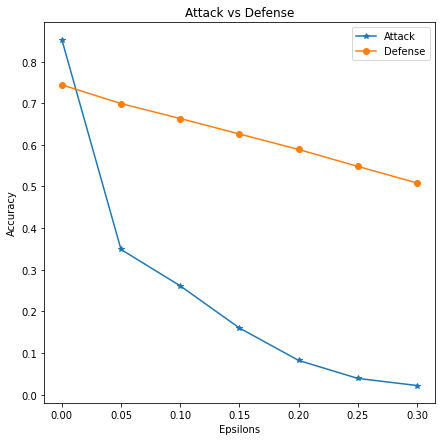

In [40]:
plot_difference(accuracies_ifgsm_attack, accuracies_ifgsm_defense)

## Bibilography

- PyTorch tutorial on [ADVERSARIAL EXAMPLE GENERATION](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
- [torchattacks](https://adversarial-attacks-pytorch.readthedocs.io/en/latest/_modules/torchattacks/attacks/mifgsm.html#MIFGSM)
- CS-747 Deep Learning, Assignment 2 for pretrained model loading and input transformation
- Adversarial attack [blog](https://medium.com/swlh/gradient-based-adversarial-attacks-an-introduction-526238660dc9)
- [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html)